### This notebook demonstrates the pipeline of modifying a ground motion to incorporate site effects (a.k.a., site response)

The users need to know the following information:

- Input ground motion (i.e., motion to be adjusted)
- Vs profile for adjusting the input motion (this is optional; if not known, the input ground motion is assumed to be on a rock site whose surface $V_S$ = 1,000 m/s)
- The $V_{S30}$ of the site of interest
- The $z_{1}$ (basin depth) of the site of interest (this is optional; if not known, it will be inferred from $V_{S30}$)

In [1]:
import numpy as np

In [2]:
from PySeismoSoil.class_ground_motion import Ground_Motion
from PySeismoSoil.class_Vs_profile import Vs_Profile
from PySeismoSoil.class_site_effect_adjustment import Site_Effect_Adjustment

## 1. Create input ground motion object

In [3]:
gm = Ground_Motion('../PySeismoSoil/tests/files/sample_accel.txt', unit='cm/s/s', motion_type='accel')

(For more information of `Ground_Motion` objects, see [documentations](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_ground_motion.html) and [examples](./Demo_01_Ground_Motion.ipynb).)

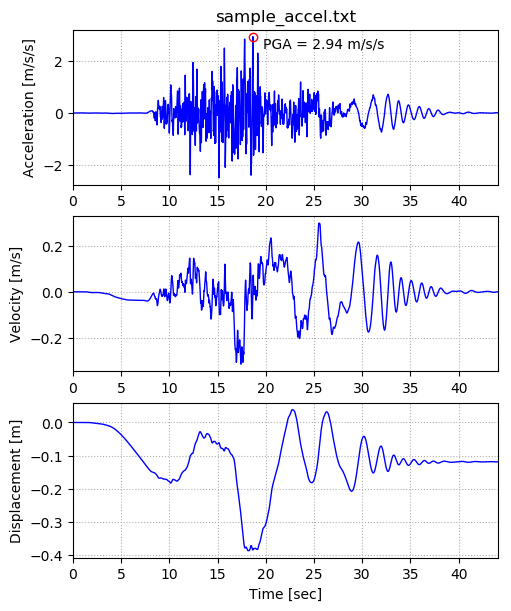

In [4]:
gm.plot();

## 2. Slightly adjust the input motion (_optional_)

If the input motion is not recorded (or simulated) on exactly a ground surface whose $V_S$ = 1,000 m/s, the users can choose to slightly adjust the input motion, by either applying/"substracting" linear site response to/from it. 

This step usually has a secondary effect, so can sometimes be neglected, if the users do not have sufficient information (such as the $V_S$ profile).

### 2.1. Adjust by deconvolution

If the input ground motion is recorded (or simulated) on ground surface with surface $V_S$ < 1,000 m/s, the input motion may already contain some soil response. Therefore, we need to "cancel out" such soil response by performing a linear deconvolution.

To do this, we need to know the $V_S$ profile beneath the original input motion. Below is an example using a generic Los Angeles basin site, and its $V_S$ profile comes from [here](https://github.com/SCECcode/BBP/wiki/File-Format-Guide#la-basin). (Note that we only need the part of the profile with $V_S \leqslant$ 1,000 m/s.)

In [5]:
data = np.array([[10,  425, 1.961, 1800, 1   ],
                 [20,  538, 1.549, 1800, 2   ],
                 [70,  650, 1.282, 1800, 3   ],
                 [100, 800, 1.042, 2000, 4   ],
                 [0,  1000, 0.883, 2000, 0  ]])
vs_prof = Vs_Profile(data, damping_unit='%', density_unit='kg/m^3')

(For more information on the `Vs_Profile` class, see [documentation](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_Vs_profile.html) and [examples](Demo_02_Vs_Profile.ipynb).)

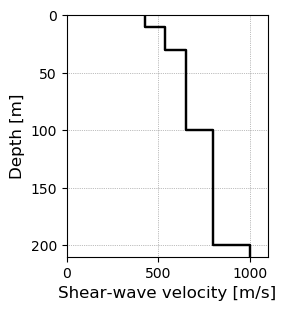

In [6]:
vs_prof.plot();

Get the deconvolved ground motion "`gm_1`" by calling the `deconvolve()` method of `gm`. We can see that the two ground motions are very similar, and the computation is pretty fast:

Wall time: 1.59 s


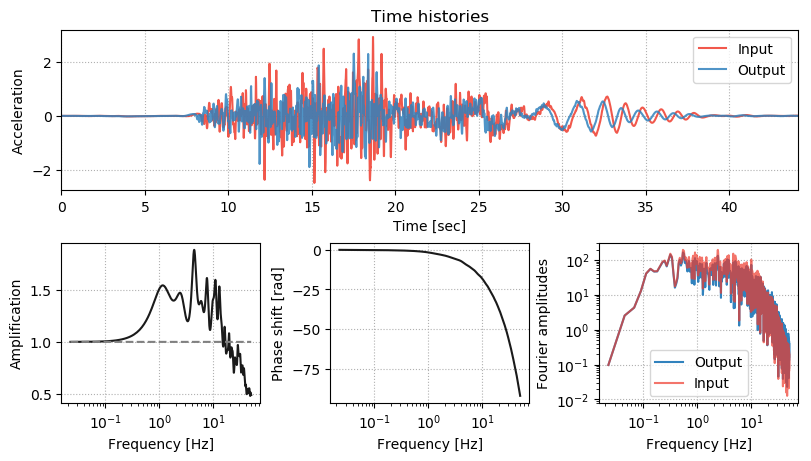

In [7]:
%time gm_1 = gm.deconvolve(vs_prof, boundary='elastic', show_fig=True) # use 'elastic' because we want rock outcrop motion

### 2.2. Adjust by (forward) convolution

Alternatively, if the original input motion is recorded (or simulated) on a ground with surface $V_S$ > 1,000 m/s, we may be missing some site amplification from propagating through the rock layers. Below is an example:

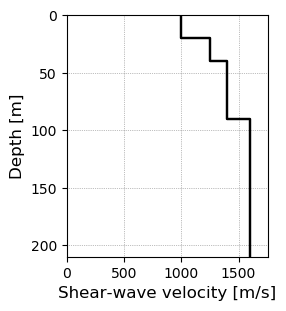

In [8]:
# create an artificial rock profile:
vs_prof_temp = Vs_Profile(np.array([[20, 1000],
                                   [20, 1250],
                                   [50, 1400],
                                   [100, 1600]]))
vs_prof_temp.plot();

Wall time: 1.11 s


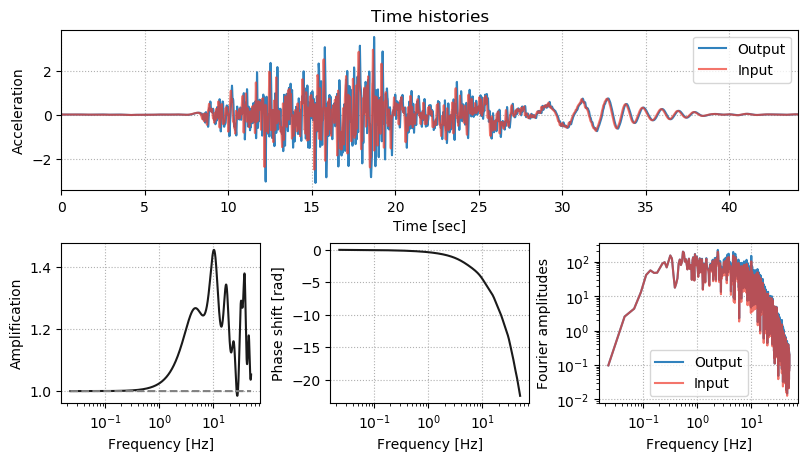

In [9]:
%%time
gm_temp = gm.amplify(vs_prof_temp, show_fig=True)

The users can ignore this step completely at their own discretion.

## 3. Apply nonlinear site effects

Here we apply nonlinear site effects to the adjusted input motion, `gm_1`. Assume the soil site of interest has a $V_{S30}$ of 220 m/s and a $z_1$ of 650 m.

In [10]:
Vs30 = 220
z1 = 650
sea = Site_Effect_Adjustment(gm_1, Vs30, z1_in_m=z1)

(For more information on the `Site_Effect_Adjustment` class, see its [documentation](https://pyseismosoil.readthedocs.io/en/stable/api_docs/class_site_effect_adjustment.html))

Wall time: 1.58 s


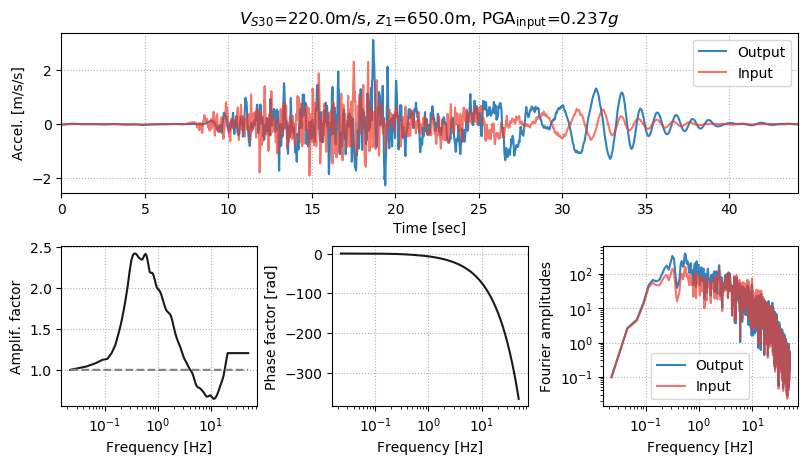

In [11]:
%%time
output_motion = sea.run(show_fig=True)

Oftentimes, users do not have information on $z_1$ (basin depth, or depth to bedrock). Then the user can provide only $V_{S30}$, and an empirical correlation will be used to determine $z_1$ from $V_{S30}$.

Wall time: 1.57 s


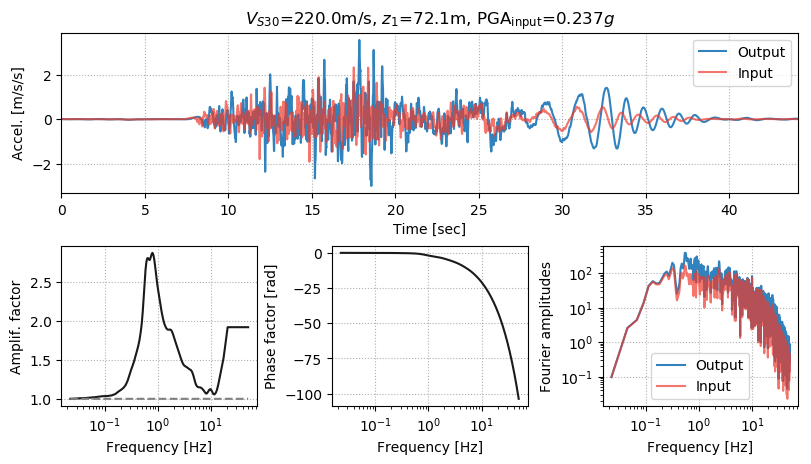

In [12]:
%%time
sea_1 = Site_Effect_Adjustment(gm_1, Vs30)
output_motion_1 = sea_1.run(show_fig=True)